In [1]:
from lib.evagg.ref import IPaperLookupClient
from lib.evagg.library import RareDiseaseFileLibrary
from lib.evagg.types import Paper
from lib.evagg.interfaces import IGetPapers
from lib.di import DiContainer

import pandas as pd
import numpy as np
import random, math, yaml, pytest, logging

/tmp/ipykernel_180014/1272528214.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Set path for manual ground truth (MGT) data CSV file

mgt_paper_finding_path = "/home/azureuser/ev-agg-exp/data/Manual_Ground_Truth_find_right_papers.csv"

In [3]:
# Read the manual ground truth (MGT) data from the CSV file

mgt_gene_pmids_df = pd.read_csv(mgt_paper_finding_path)

# Initialize dictionary to store the gene names and their corresponding PMIDs
mgt_gene_pmids_dict = {}

# Iterate over the rows and parse the ones we care about
for index in range(len(mgt_gene_pmids_df) - 1):
    # Get the gene name
    gene = mgt_gene_pmids_df.iloc[index]['gene']
    
    # Skip rows without a gene name (e.g. notes or process)
    if pd.isna(gene):
        continue
    
    # Get the PMIDs
    pmids = mgt_gene_pmids_df.iloc[index, 5:].dropna().tolist()
    
    # Get the exclusion marks (to exclude PMIDs that are marked with 'x', i.e. not relevant for V1)
    marks = mgt_gene_pmids_df.iloc[index + 1, 5:].tolist()
    
    # Exclude the PMIDs that are marked with 'x'
    pmids = [pmid for pmid, mark in zip(pmids, marks) if mark != 'x']
    
    # Add the gene and PMIDs to the dictionary
    mgt_gene_pmids_dict[gene] = pmids

# Get the first key-value pair
first_key = list(mgt_gene_pmids_dict.keys())[0]
first_value = mgt_gene_pmids_dict[first_key]

print(f"Structure of manual ground truth data dataframe:\n {first_key}: {first_value}\n ...") 

Structure of manual ground truth data dataframe:
 CTF1: ['11058912', '24503780', '26084686']
 ...


In [4]:
# Split genes into train 70% and test 30% 

# Get the list of genes
genes = sorted(list(mgt_gene_pmids_dict.keys()))

# Shuffle the list
random.seed(0)
random.shuffle(genes)

# Calculate the index for splitting
split_index = math.ceil(0.7 * len(genes))

# Split the list into train and test
train = genes[:split_index]
test = genes[split_index:]

print("Train:", len(train), train)
print("Test:", len(test), test)

# Filter mgt_paper_finding_dict to only include genes in train
train_mgt_paper_finding_dict = {gene: mgt_gene_pmids_dict[gene] for gene in train}

# Filter mgt_paper_finding_dict to only include genes in train
test_mgt_paper_finding_dict = {gene: mgt_gene_pmids_dict[gene] for gene in test}

Train: 32 ['ADCY1', 'RHOH', 'FBN2', 'ACAT2', 'TAPBP', 'LRRC10', 'EXOC2', 'CTF1', 'TOPBP1', 'TNNC2', 'PEX11A', 'KMO', 'GRXCR2', 'CPT1B', 'COG4', 'MLH3', 'HYAL1', 'EMC1', 'TOP2B', 'OTUD7A', 'DNAJC7', 'SARS1', 'NPPA', 'RNASEH1', 'IGKC', 'RGS9', 'SLFN14', 'SLC38A9', 'B4GAT1', 'ZNF423', 'BAZ2B', 'JPH2']
Test: 13 ['DECR1', 'TDO2', 'FOXE3', 'MIB1', 'PEX11G', 'KIF1B', 'NDUFA2', 'PRPH', 'PTCD3', 'HYKK', 'AHCY', 'NLGN3', 'MPST']


In [5]:
 
# Get the manual ground truth (MGT) training data PMIDs for a gene.
def get_ground_truth_pmids(gene, train_mgt_paper_finding_dict):
    if gene in train_mgt_paper_finding_dict.keys():
        return train_mgt_paper_finding_dict[gene]
    else:
        print(gene, "not in ground truth training data")
        return None

# Compare the papers that were found to the manual ground truth (MGT) training data papers
def compare_to_truth_or_tool(gene, input_papers, is_pubmed, ncbi_lookup):
    """Compare the papers that were found to the ground truth papers.
    Args:
        paper (Paper): The paper to compare.
    Returns:
        number of correct papers (i.e. the number that match the MGT training data papers)
        number of missed papers (i.e. the number that are in the MGT training data papers but not in the papers that were found)
        number of extra papers (i.e. the number that are in the papers that were found but not in the MGT training data papers)
    """

    # Get all the PMIDs from all of the papers
    #r_d_pmids = [(paper.props.get("pmid", "Unknown"), paper.props.get("title", "Unknown")) for paper in r_d_papers]
    input_paper_pmids = [(getattr(paper, 'props', {}).get("pmid", "Unknown"), getattr(paper, 'props', {}).get("title", "Unknown")) for paper in input_papers]

    ground_truth_gene_pmids = get_ground_truth_pmids(gene, train_mgt_paper_finding_dict)

    # Keep track of the correct and extra PMIDs to subtract from the MGT training data papers PMIDs
    counted_pmids = []
    correct_pmids = []
    missed_pmids = []
    irrelevant_pmids = []

    # For each gene, get MGT training data PMIDs from ground_truth_papers_pmids and compare those PMIDS to the PMIDS from the papers that the tool found (e.g. our ev. agg. tool or PubMed).
    if ground_truth_gene_pmids is not None:
        for pmid, title in input_paper_pmids:
            if pmid in ground_truth_gene_pmids:
                counted_pmids.append(pmid)
                correct_pmids.append((pmid, title))

            else:
                counted_pmids.append(pmid)
                irrelevant_pmids.append((pmid, title))

        # For any PMIDs in the MGT training data that are not in the papers that were found, increment n_missed, use counted_pmids to subtract from the MGT training data papers PMIDs
        for pmid in ground_truth_gene_pmids:
            if pmid not in counted_pmids:
                missed_paper_title = ncbi_lookup.fetch(str(pmid))
                missed_paper_title = (
                    missed_paper_title.props.get("title", "Unknown")
                    if missed_paper_title is not None
                    else "Unknown"
                )
                missed_pmids.append((pmid, missed_paper_title))

    if is_pubmed:  # comparing PubMed results to MGT training data
        print("\nOf PubMed papers...")
        print("Pubmed # Correct Papers: ", len(correct_pmids))
        print("Pubmed # Missed Papers: ", len(missed_pmids))
        print("Pubmed # Irrelevant Papers: ", len(irrelevant_pmids))

        print(f"\nFound Pubmed {len(correct_pmids)} correct.")
        for i, p in enumerate(correct_pmids):
            print("*", i + 1, "*", p[0], "*", p[1])

        print(f"\nFound Pubmed {len(missed_pmids)} missed.")
        for i, p in enumerate(missed_pmids):
            print("*", i + 1, "*", p[0], "*", p[1])

        print(f"\nFound Pubmed {len(irrelevant_pmids)} irrelevant.")
        for i, p in enumerate(irrelevant_pmids):
            print("*", i + 1, "*", p[0], "*", p[1])
    else:  # Comparing tool to manual ground truth (MGT) training data
        print("\nOf the rare disease papers...")
        print("Tool # Correct Papers: ", len(correct_pmids))
        print("Tool # Missed Papers: ", len(missed_pmids))
        print("Tool # Irrelevant Papers: ", len(irrelevant_pmids))

        print(f"\nFound tool {len(correct_pmids)} correct.")
        for i, p in enumerate(correct_pmids):
            print("*", i + 1, "*", p[0], "*", p[1])

        print(f"\nFound tool {len(missed_pmids)} missed.")
        for i, p in enumerate(missed_pmids):
            print("*", i + 1, "*", p[0], "*", p[1])

        print(f"\nFound tool {len(irrelevant_pmids)} irrelevant.")
        for i, p in enumerate(irrelevant_pmids):
            print("*", i + 1, "*", p[0], "*", p[1])

    return correct_pmids, missed_pmids, irrelevant_pmids

In [7]:
# Compare our tool's paper finding pipeline to the manual ground truth (MGT) training data for rare disease papers

logging.getLogger().setLevel(logging.CRITICAL)

# Open and load the .yaml file
with open('/home/azureuser/ev-agg-exp/lib/config/pubmed_library_config.yaml', 'r') as file:
    yaml_data = yaml.safe_load(file)
    
# Get max_papers parameter
max_papers = yaml_data['library']['max_papers'] # TODO: use this parameter to limit the number of papers to fetch

# Get the query/ies
query_list_yaml = []
for query in yaml_data['queries']:
    # Extract the values, or use an empty string if they're missing
    gene_symbol = query.get('gene_symbol', '')
    min_date = query.get('min_date', '')
    max_date = query.get('max_date', '')
    date_type = query.get('date_type', '')

    # Create a new dictionary with the gene_symbol and the values, '' in places where .yaml does not show a value
    new_dict = {'gene_symbol': gene_symbol, 'min_date': min_date, 'max_date': max_date, 'date_type': date_type}
    
    # Add the new dictionary to the list
    query_list_yaml.append(new_dict)
    
# Create the library and the PubMed lookup clients
library: RareDiseaseFileLibrary = DiContainer().create_instance({"di_factory": "lib/config/library.yaml"}, {})
ncbi_lookup: IPaperLookupClient = DiContainer().create_instance({"di_factory": "lib/config/ncbi_lookup.yaml"}, {})

# Get the papers for each query, compare tool papers to the MGT training data papers, and compare PubMed papers to the MGT training data papers
for query in query_list_yaml:
    rare_disease_papers, count_r_d_papers, non_rare_disease_papers, other_papers = library.get_papers(query)
    term = query['gene_symbol']
    
    if count_r_d_papers != 0:
        # Compare our tool papers (PMIDs) to the MGT training data papers (PMIDs)
        correct_pmids_papers, missed_pmids_papers, irrelevant_pmids_papers = compare_to_truth_or_tool(term, rare_disease_papers, 0, ncbi_lookup)
        papers = rare_disease_papers.union(non_rare_disease_papers, other_papers)
    else:
        # No need to group rare_disease_papers as empty set.
        papers = non_rare_disease_papers.union(other_papers)
    
    # Compare PubMed papers to the MGT training data papers
    pn_corr, pn_miss, pn_extra = compare_to_truth_or_tool(term, papers, 1, ncbi_lookup)


GENE:  ADCY1
Rare Disease Papers:  0
Non-Rare Disease Papers:  2
Other Papers:  3

Of PubMed papers...
Pubmed # Correct Papers:  0
Pubmed # Missed Papers:  1
Pubmed # Irrelevant Papers:  5

Found Pubmed 0 correct.

Found Pubmed 1 missed.
* 1 * 24482543 * Adenylate cyclase 1 (ADCY1) mutations cause recessive hearing impairment in humans and defects in hair cell function and hearing in zebrafish.

Found Pubmed 5 irrelevant.
* 1 * 36242624 * CUX2 prevents the malignant progression of gliomas by enhancing ADCY1 transcription.
* 2 * 37465213 * Ca2+-stimulated ADCY1 and ADCY8 regulate distinct aspects of synaptic and cognitive flexibility.
* 3 * 31839819 * A perspective profile of ADCY1 in cAMP signaling with drug-resistance in lung cancer.
* 4 * 34650124 * GNG7 and ADCY1 as diagnostic and prognostic biomarkers for pancreatic adenocarcinoma through bioinformatic-based analyses.
* 5 * 35076816 * Circ-LTBP1 is involved in doxorubicin-induced intracellular toxicity in cardiomyocytes via miR-10

In [ ]:
# # Run through paper finding benchmarks on the training set

# def run_paper_finding_benchmarks(term, papers, rare_disease_papers, get_ground_truth_pmids):
    
#     # Calculate # correct, # missed, and # irrelevant papers for our tool against the manual ground truth    
#     ea_correct_pmids, ea_missed_pmids, ea_irrelevant_pmids = calc_metrics_against_manual_ground_truth(term, rare_disease_papers, get_ground_truth_pmids)
    
#     # if not rare_disease_papers:
#     #     rare_disease_papers = set()

#     # Calculate # correct, # missed, and # irrelevant papers for our tool against PubMed
#     pub_correct_pmids, pub_missed_pmids, pub_irrelevant_pmids = calc_metrics_against_manual_ground_truth(term, papers, get_ground_truth_pmids)
    
#     return ea_correct_pmids, ea_missed_pmids, ea_irrelevant_pmids, pub_correct_pmids, pub_missed_pmids, pub_irrelevant_pmids
       
# # Get the ground truth PMIDs for a gene.
# def get_ground_truth_pmids(gene, mgt_gene_pmids_dict):
#     if gene in mgt_gene_pmids_dict.keys():
#         return mgt_gene_pmids_dict[gene]
#     else:
#         return None

# # Compare the ground truth papers PMIDs to the papers (our tool or PubMed's papers) that were found
# def calc_metrics_against_manual_ground_truth(term, input_papers, mgt_gene_pmids_dict):
#     """Compare the papers that were found to the ground truth papers.
#     Args:
#         paper (Paper): The paper to compare.
#     Returns:
#         number of correct papers (i.e. the number that match the ground truth)
#         number of missed papers (i.e. the number that are in the ground truth but not in the papers that were found)
#         number of irrelevant papers (i.e. the number that are in the papers that were found but not in the ground truth)
#     """

#     # Get all the PMIDs from all of the papers
#     input_paper_pmids = [paper.props.get("pmid", "Unknown") for paper in input_papers]

#     # Get the ground truth PMIDs list for the gene
#     ground_truth_gene_pmids = get_ground_truth_pmids(term, mgt_gene_pmids_dict)

#     # Keep track of the correct, missed, and irrelevant PMIDs to subtract from the ground truth papers PMIDs
#     counted_pmids = []
#     correct_pmids = []
#     missed_pmids = []
#     irrelevant_pmids = []

#     # For each gene, get ground truth PMIDs from ground_truth_papers_pmids and compare those PMIDS to the PMIDS from the papers that the tool found (e.g. our ev. agg. tool or PubMed).
#     if ground_truth_gene_pmids is not None:
#         for pmid in input_paper_pmids:
#             if pmid in ground_truth_gene_pmids:
#                 counted_pmids.append(pmid)
#                 correct_pmids.append(pmid)

#             else:
#                 print("irrelevant pmid: ", pmid)
#                 counted_pmids.append(pmid)
#                 irrelevant_pmids.append(pmid)

#         # For any PMIDs in the ground truth that are not in the papers that were found, increment n_missed, use counted_pmids to subtract from the ground truth papers PMIDs
#         for pmid in ground_truth_gene_pmids:
#             if pmid not in counted_pmids:
#                 print("missed pmid: ", pmid)
#                 missed_pmids.append(pmid)

#     print(
#         f"Compared to Manual Ground Truth - Correct: {len(correct_pmids)}, Missed: {len(missed_pmids)}, Irrelevant: {len(irrelevant_pmids)}"
#     )

#     return correct_pmids, missed_pmids, irrelevant_pmids

# def get_paper_titles(input_pmids, input_papers):
#     # Filter input_papers and create 3 objects that each have all of the paper titles, which correspond to the pmids in correct_pmids, missed_pmids, and irrelevant_pmids.
#     input_pmid_titles = [
#         paper.props.get("title", "Unknown")
#         for paper in input_papers
#         if paper.props.get("pmid", "Unknown") in input_pmids
#     ]
#     # paper_abstract = paper.props.get("abstract", "Unknown")
#     return input_pmid_titles

In [6]:
# # Run the paper finding benchmarks on the training set
# for gene in train_mgt_paper_finding_dict:
#     print(f"Running paper finding benchmarks for gene: {gene}")
#     term = gene
#     papers = RareDiseaseFileLibrary.get_rare_disease_papers(term)
#     rare_disease_papers = RareDiseaseFileLibrary.get_rare_disease_papers(term)
#     ea_correct_pmids, ea_missed_pmids, ea_irrelevant_pmids, pub_correct_pmids, pub_missed_pmids, pub_irrelevant_pmids = run_paper_finding_benchmarks(term, papers, rare_disease_papers, mgt_gene_pmids_dict)
#     print(f"EA Correct PMIDs: {ea_correct_pmids}")
#     print(f"EA Missed PMIDs: {ea_missed_pmids}")
#     print(f"EA Irrelevant PMIDs: {ea_irrelevant_pmids}")
#     print(f"Pub Correct PMIDs: {pub_correct_pmids}")
#     print(f"Pub Missed PMIDs: {pub_missed_pmids}")
#     print(f"Pub Irrelevant PMIDs: {pub_irrelevant_pmids}")


In [3]:
gene_dict = {'CTF1': ['11058912', '24503780', '26084686'], 'FBN2': ['9714438', '9737771', '10797416', '11754102', '15121784', '17345643', '19006240', '19473076', '24585410', '24833718', '24899048', '27625873', '25834781', '25975422', '27007659', '27196565', '27606123', '27912749', '28379158', '28383543', '29742989', '29864108', '30147916', '30675029', '31316167', '31426022', '31506931', '32184806', '32900841', '33571691', '33638605', '34355836', '34456093', '35126451', '35360850', '35754816', '36800380', '36849876', '36936417', '37254066', '37399314', '37875969', '37962692', '38099230', '38114583', '38215673', '38326314'], 'EXOC2': ['32639540'], 'RHOH': ['22850876'], 'RNASEH1': ['30340744', '28508084', '31258551', '26094573', '33396418'], 'TDO2': ['28285122', '35743796'], 'DNAJC7': ['31768050', '32897108', '33193563', '34233860', '35039179', '35456894', '37870677', '38112783'], 'PTCD3': ['36450274', '30706245', '30607703'], 'ZNF423': ['32925911', '33531950', '33270637', '22863007'], 'OTUD7A': ['33381903', '31997314'], 'PRPH': ['15322088', '15446584', '20363051', '25299611', '26742954', '17045786', '30992453', '35714755'], 'ADCY1': ['24482543'], 'IGKC': ['32278584', '26853951', '4132042'], 'SARS1': ['35790048', '36041817', '34570399'], 'BAZ2B': ['31999386', '25363768', '28135719', '28554332', '28867142', '31398340', '31981491', '33057194', '37872713'], 'NDUFA2': ['18513682', '27159321', '28857146', '32154054'], 'TAPBP': ['12149238'], 'AHCY': ['19177456', '20852937', '22959829', '26095522', '26527160', '26974671', '28779239', '30121674', '31957987', '32689861', '33869213', '35789945', '38052822', '15024124', '16736098', '27848944', '35463910'], 'B4GAT1': ['34587870', '34602496', '25279699', '23877401'], 'TOP2B': ['31198993', '31409799', '31953910', '35063500', '36450898', '37068767', '32128574'], 'SLFN14': ['30431218', '31378119', '37140956', '36790527', '26280575', '33496736', '29678925', '37041648', '36237120', '26769223', '30536060'], 'HYAL1': ['10339581', '21559944', '26322170'], 'RGS9': ['17826834', '14702087', '29107794', '19818506'], 'MLH3': ['11586295', '12702580', '12800209', '15193445', '16885347', '16981255', '18521850', '19156873', '24549055', '25142776', '26149658', '26296701', '26542077', '27401157', '30573798', '30614234', '31297992', '32469048', '33117677', '33517345', '34008015', '34897210', '35475445', '37656691', '38201513', '28195393', '29212164'], 'COG4': ['19494034', '19651599', '21185756', '30290151', '31949312', '32078278', '32652690', '33340551', '33629572', '33688625', '34022244', '34298581', '34595172', '34603392', '35455576', '36393834'], 'JPH2': ['17476457', '17509612', '20694023', '22515980', '23973696', '24636942', '24935431', '25500949', '27471098', '30167555', '28393127', '30235249', '30384889', '31227780', '31478477', '32879264', '34394822', '34526680', '34861382', '35001666', '35238659', '36357925', '37371654', '29540472', '29165669'], 'NLGN3': ['12669065', '24126926', '25167861', '25363768', '25533962', '28263302', '15150161', '19360662', '20615874', '21808020', '15274046', '15679194', '16077734', '16429495', '16508939', '16648374', '18189281', '18361425', '18419324', '18555979', '19545994', '19645625', '20227402', '21569590', '22934180', '23020841', '23468870', '23761734', '23851596', '23871722', '24362370', '24570023', '25347860', '25464930', '25592157', '26469287', '27743928', '27782075', '28385162', '28584888', '28948087', '29028156', '30201312', '31119867', '31184401', '31827744', '32848696', '34262438', '34690695', '36280753', '36810932', '38255906'], 'FOXE3': ['26854927', '26995144', '28418495', '29136273', '29314435', '29878917', '30078984', '31884615', '32224865', '32436650', '32499604', '32976546', '34046667', '35051625', '35170016', '36192130', '37628625', '37758467'], 'GRXCR2': ['24619944', '28383030', '32048449', '30157177', '33528103'], 'EMC1': ['36799557', '35234901', '37187958', '26942288', '32092440', '29271071', '38161285', '35684946', '37554197', '32869858'], 'PEX11G': ['26935981'], 'KMO': ['23459468'], 'MIB1': [], 'MPST': [], 'SLC38A9': [], 'HYKK': [], 'CPT1B': [], 'TNNC2': [], 'NPPA': [], 'LRRC10': ['26017719', '29431102', '28032242', '27536250', '29431105', '31270560'], 'TOPBP1': ['24702692', '34199176'], 'PEX11A': [], 'DECR1': [], 'ACAT2': [], 'KIF1B': ['11389829', '30126838', '16163269', '16877806', '18726616', '22595495', '25802885', '27986441', '32298515', '33112832', '33362715', '33397043', '34169998', '35046208', '37564981', '37780619']}


In [4]:
text = """
ADCY1   train
RHOH    train
FBN2    train
ACAT2   train
TAPBP   train
LRRC10  train
EXOC2   train
CTF1    train
TOPBP1  train
TNNC2   train
PEX11A  train
KMO train
GRXCR2  train
CPT1B   train
COG4    train
MLH3    train
HYAL1   train
EMC1    train
TOP2B   train
OTUD7A  train
DNAJC7  train
SARS1   train
NPPA    train
RNASEH1 train
IGKC    train
RGS9    train
SLFN14  train
SLC38A9 train
B4GAT1  train
ZNF423  train
BAZ2B   train
JPH2    train
"""

# Split the text into lines, remove 'train' and strip extra whitespace
train_genes = [line.replace('train', '').strip() for line in text.split('\n') if line]

print(train_genes)

formatted_genes = [f"- '{gene}:something'" for gene in train_genes]

for gene in formatted_genes:
    print(gene)

['ADCY1', 'RHOH', 'FBN2', 'ACAT2', 'TAPBP', 'LRRC10', 'EXOC2', 'CTF1', 'TOPBP1', 'TNNC2', 'PEX11A', 'KMO', 'GRXCR2', 'CPT1B', 'COG4', 'MLH3', 'HYAL1', 'EMC1', 'TOP2B', 'OTUD7A', 'DNAJC7', 'SARS1', 'NPPA', 'RNASEH1', 'IGKC', 'RGS9', 'SLFN14', 'SLC38A9', 'B4GAT1', 'ZNF423', 'BAZ2B', 'JPH2']
- 'ADCY1:something'
- 'RHOH:something'
- 'FBN2:something'
- 'ACAT2:something'
- 'TAPBP:something'
- 'LRRC10:something'
- 'EXOC2:something'
- 'CTF1:something'
- 'TOPBP1:something'
- 'TNNC2:something'
- 'PEX11A:something'
- 'KMO:something'
- 'GRXCR2:something'
- 'CPT1B:something'
- 'COG4:something'
- 'MLH3:something'
- 'HYAL1:something'
- 'EMC1:something'
- 'TOP2B:something'
- 'OTUD7A:something'
- 'DNAJC7:something'
- 'SARS1:something'
- 'NPPA:something'
- 'RNASEH1:something'
- 'IGKC:something'
- 'RGS9:something'
- 'SLFN14:something'
- 'SLC38A9:something'
- 'B4GAT1:something'
- 'ZNF423:something'
- 'BAZ2B:something'
- 'JPH2:something'


In [10]:
# Parse benchmarking results from its analyst readable format to a dictionary
benchmarking_results = {}
with open('/home/azureuser/ev-agg-exp/blah.txt', 'r') as f:
    lines = f.readlines()
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if line.startswith('GENE:'):
            gene = line.split()[1]
            i += 1
            while i < len(lines) and not lines[i].startswith('GENE:'):
                if lines[i].startswith('Rare Disease Papers:'):
                    rare_disease_papers = int(lines[i].split(':')[1].strip())
                elif lines[i].startswith('Non-Rare Disease Papers:'):
                    non_rare_disease_papers = int(lines[i].split(':')[1].strip())
                elif lines[i].startswith('Other Papers:'):
                    other_papers = int(lines[i].split(':')[1].strip())
                elif lines[i].startswith('Tool # Correct Papers:'):
                    tool_correct_papers = int(lines[i].split(':')[1].strip())
                elif lines[i].startswith('Tool # Missed Papers:'):
                    tool_missed_papers = int(lines[i].split(':')[1].strip())
                elif lines[i].startswith('Tool # Irrelevant Papers:'):
                    tool_irrelevant_papers = int(lines[i].split(':')[1].strip())
                elif lines[i].startswith('Pubmed # Correct Papers:'):
                    pubmed_correct_papers = int(lines[i].split(':')[1].strip())
                elif lines[i].startswith('Pubmed # Missed Papers:'):
                    pubmed_missed_papers = int(lines[i].split(':')[1].strip())
                elif lines[i].startswith('Pubmed # Irrelevant Papers:'):
                    pubmed_irrelevant_papers = int(lines[i].split(':')[1].strip())
                i += 1
            benchmarking_results[gene] = [rare_disease_papers, non_rare_disease_papers, other_papers, tool_correct_papers, tool_missed_papers, tool_irrelevant_papers, pubmed_correct_papers, pubmed_missed_papers, pubmed_irrelevant_papers]
        else:
            i += 1  # Go to the next line

In [11]:
benchmarking_results

{'ADCY1': [10, 7, 33, 1, 0, 9, 1, 0, 49],
 'RHOH': [7, 5, 38, 1, 0, 6, 1, 0, 49],
 'FBN2': [36, 3, 8, 13, 34, 23, 15, 32, 32],
 'ACAT2': [2, 7, 41, 0, 0, 2, 0, 0, 50],
 'TAPBP': [9, 9, 32, 0, 1, 9, 0, 1, 50],
 'LRRC10': [3, 0, 17, 3, 3, 0, 6, 0, 14],
 'EXOC2': [11, 6, 33, 1, 0, 10, 1, 0, 49],
 'CTF1': [8, 6, 36, 1, 2, 7, 1, 2, 49],
 'TOPBP1': [6, 13, 31, 0, 2, 6, 0, 2, 50],
 'TNNC2': [10, 9, 25, 0, 0, 10, 0, 0, 44],
 'PEX11A': [8, 3, 34, 0, 0, 8, 0, 0, 45],
 'KMO': [22, 9, 19, 1, 0, 21, 1, 0, 49],
 'GRXCR2': [4, 0, 5, 2, 3, 2, 4, 1, 5],
 'CPT1B': [8, 7, 35, 0, 0, 8, 0, 0, 50],
 'COG4': [25, 1, 22, 15, 1, 10, 15, 1, 33],
 'MLH3': [25, 8, 17, 7, 20, 18, 8, 19, 42],
 'HYAL1': [11, 20, 18, 2, 1, 9, 3, 0, 46],
 'EMC1': [15, 3, 15, 9, 1, 6, 10, 0, 23],
 'TOP2B': [14, 12, 24, 4, 3, 10, 4, 3, 46],
 'OTUD7A': [19, 3, 5, 2, 0, 17, 2, 0, 25],
 'DNAJC7': [13, 2, 28, 7, 1, 6, 8, 0, 35],
 'SARS1': [19, 0, 18, 3, 0, 16, 3, 0, 34],
 'NPPA': [15, 5, 30, 0, 0, 15, 0, 0, 50],
 'RNASEH1': [16, 12, 22, 3, 

In [26]:
# Python
keys = ['Gene', 'Rare Disease Papers', 'Non-Rare Disease Papers', 'Other Papers', 'Tool Correct', 'Tool Missed', 'Tool Irrelevant', 'PubMed Correct', 'PubMed Missed', 'PubMed Irrelevant']
results_to_plot = {key: [] for key in keys}

for gene, values in benchmarking_results.items():
    for i, key in enumerate(keys):
        if key == 'Gene':
            results_to_plot[key].append(gene)
        else:
            results_to_plot[key].append(values[i-1])
            
results_to_plot = pd.DataFrame(results_to_plot)

In [27]:
results_to_plot 

,Gene,Rare Disease Papers,Non-Rare Disease Papers,Other Papers,Tool Correct,Tool Missed,Tool Irrelevant,PubMed Correct,PubMed Missed,PubMed Irrelevant
0,ADCY1,10,7,33,1,0,9,1,0,49
1,RHOH,7,5,38,1,0,6,1,0,49
2,FBN2,36,3,8,13,34,23,15,32,32
3,ACAT2,2,7,41,0,0,2,0,0,50
4,TAPBP,9,9,32,0,1,9,0,1,50
5,LRRC10,3,0,17,3,3,0,6,0,14
6,EXOC2,11,6,33,1,0,10,1,0,49
7,CTF1,8,6,36,1,2,7,1,2,49
8,TOPBP1,6,13,31,0,2,6,0,2,50
9,TNNC2,10,9,25,0,0,10,0,0,44


In [32]:
{key: len(value) for key, value in results_to_plot.items()}

{'Gene': 32,
 'Rare Disease Papers': 32,
 'Non-Rare Disease Papers': 32,
 'Other Papers': 32,
 'Tool Correct': 32,
 'Tool Missed': 32,
 'Tool Irrelevant': 32,
 'PubMed Correct': 32,
 'PubMed Missed': 32,
 'PubMed Irrelevant': 32}

3.125
3.40625
9.09375
3.96875
2.5625
39.375


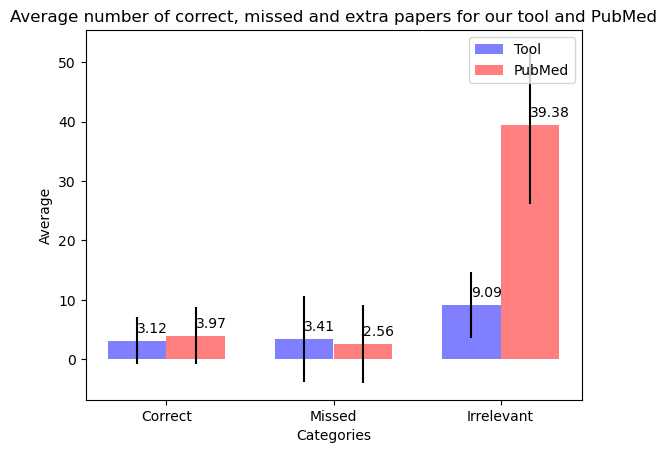

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate averages
tool_averages = results_to_plot[['Tool Correct', 'Tool Missed', 'Tool Irrelevant']].mean()
pubmed_averages = results_to_plot[['PubMed Correct', 'PubMed Missed', 'PubMed Irrelevant']].mean()

# Calculate standard deviations
tool_std = results_to_plot[['Tool Correct', 'Tool Missed', 'Tool Irrelevant']].std()
pubmed_std = results_to_plot[['PubMed Correct', 'PubMed Missed', 'PubMed Irrelevant']].std()

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Define bar width
bar_width = 0.35

# Positions of the left bar boundaries
bar_l = np.arange(len(tool_averages))

# Positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i + (bar_width / 2) for i in bar_l]

# Create a bar plot for 'Tool'
tool_bars = ax.bar(bar_l, 
       # using the 'Tool' data
       tool_averages, 
       # set the width
       width = bar_width,
       # with the label 'Tool'
       label = 'Tool', 
       # with alpha 0.5
       alpha = 0.5, 
       # with color
       color = 'b',
       # with error
       yerr = tool_std)

# Create a bar plot for 'PubMed'
pubmed_bars = ax.bar(bar_l + bar_width, 
       # using the 'PubMed' data
       pubmed_averages, 
       # set the width
       width = bar_width,
       # with the label 'PubMed'
       label = 'PubMed', 
       # with alpha 0.5
       alpha = 0.5, 
       # with color
       color = 'r',
       # with error
       yerr = pubmed_std)

# Set the ticks to be first names
plt.xticks(tick_pos, tool_averages.index)
ax.set_ylabel("Average")
ax.set_xlabel("Categories")
plt.legend(loc='upper right')
plt.title("Average number of correct, missed and extra papers for our tool and PubMed")

# Function to add labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        print(height)
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height + 0.9,
                '%.2f' % height,
                ha='left', va='bottom')

# Call the function for each barplot
add_labels(tool_bars)
add_labels(pubmed_bars)
# Set the ticks to be first names
plt.xticks(tick_pos, ['Correct', 'Missed', 'Irrelevant'])

# Let's display the plot
plt.show()


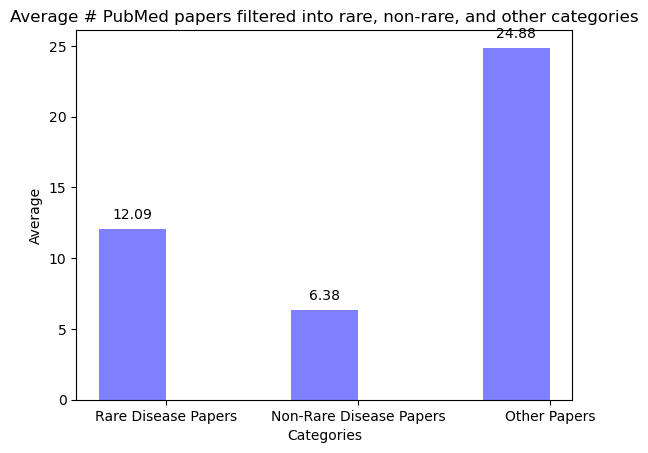

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate averages
rare_disease_avg = results_to_plot['Rare Disease Papers'].mean()
non_rare_disease_avg = results_to_plot['Non-Rare Disease Papers'].mean()
other_papers_avg = results_to_plot['Other Papers'].mean()

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Define bar width
bar_width = 0.35

# Positions of the left bar boundaries
bar_l = np.arange(3)

# Positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i + (bar_width / 2) for i in bar_l]

# Create a bar plot
bars = ax.bar(bar_l, 
       # using the data
       [rare_disease_avg, non_rare_disease_avg, other_papers_avg], 
       # set the width
       width = bar_width,
       # with alpha 0.5
       alpha = 0.5, 
       # with color
       color = 'b')

# Set the ticks to be first names
plt.xticks(tick_pos, ['Rare Disease Papers', 'Non-Rare Disease Papers', 'Other Papers'])
ax.set_ylabel("Average")
ax.set_xlabel("Categories")
plt.title("Average # PubMed papers filtered into rare, non-rare, and other categories")
# Function to add labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height + 0.5,
                '%.2f' % float(height),
                ha='center', va='bottom')

# Call the function for each barplot
add_labels(bars)

# Let's display the plot
plt.show()


In [ ]:
# To throw away
ground_truth_papers_pmids = {
        "CTF1": ["11058912", "24503780", "26084686"],
        "FBN2": [
            "9714438",
            "9737771",
            "10797416",
            "11754102",
            "15121784",
            "17345643",
            "19006240",
            "19473076",
            "24585410",
            "24833718",
            "24899048",
            "27625873",
            "25834781",
            "25975422",
            "27007659",
            "27196565",
            "27606123",
            "27912749",
            "28379158",
            "28383543",
            "29742989",
            "29864108",
            "30147916",
            "30675029",
            "31316167",
            "31426022",
            "31506931",
            "32184806",
            "32900841",
            "33571691",
            "33638605",
            "34355836",
            "34456093",
            "35126451",
            "35360850",
            "35754816",
            "36800380",
            "36849876",
            "36936417",
            "37254066",
            "37399314",
            "37875969",
            "37962692",
            "38099230",
            "38114583",
            "38215673",
            "38326314",
        ],
        "EXOC2": ["32639540"],
        "RHOH": ["22850876"],
        "RNASEH1": ["30340744", "28508084", "31258551", "26094573", "33396418"],
        "TDO2": ["28285122", "35743796"],
        "DNAJC7": ["31768050", "32897108", "33193563", "34233860", "35039179", "35456894", "37870677", "38112783"],
        "PTCD3": ["36450274", "30706245", "30607703"],
        "ZNF423": ["32925911", "33531950", "33270637", "22863007"],
        "OTUD7A": ["33381903", "31997314"],
        "PRPH": ["15322088", "15446584", "20363051", "25299611", "26742954", "17045786", "30992453", "35714755"],
        "ADCY1": ["24482543"],
        "IGKC": ["32278584", "26853951", "4132042"],
        "SARS1": ["35790048", "36041817", "34570399"],
        "BAZ2B": [
            "31999386",
            "25363768",
            "28135719",
            "28554332",
            "28867142",
            "31398340",
            "31981491",
            "33057194",
            "37872713",
        ],
        "NDUFA2": ["18513682", "27159321", "28857146", "32154054"],
        "TAPBP": ["12149238"],
        "AHCY": [
            "19177456",
            "20852937",
            "22959829",
            "26095522",
            "26527160",
            "26974671",
            "28779239",
            "30121674",
            "31957987",
            "32689861",
            "33869213",
            "35789945",
            "38052822",
            "15024124",
            "16736098",
            "27848944",
            "35463910",
        ],
        "B4GAT1": ["34587870", "34602496", "25279699", "23877401"],
        "TOP2B": ["31198993", "31409799", "31953910", "35063500", "36450898", "37068767", "32128574"],
        "SLFN14": [
            "30431218",
            "31378119",
            "37140956",
            "36790527",
            "26280575",
            "33496736",
            "29678925",
            "37041648",
            "36237120",
            "26769223",
            "30536060",
        ],
        "HYAL1": ["10339581", "21559944", "26322170"],
        "RGS9": ["17826834", "14702087", "29107794", "19818506"],
        "MLH3": [
            "11586295",
            "12702580",
            "12800209",
            "15193445",
            "16885347",
            "16981255",
            "18521850",
            "19156873",
            "24549055",
            "25142776",
            "26149658",
            "26296701",
            "26542077",
            "27401157",
            "30573798",
            "30614234",
            "31297992",
            "32469048",
            "33117677",
            "33517345",
            "34008015",
            "34897210",
            "35475445",
            "37656691",
            "38201513",
            "28195393",
            "29212164",
        ],
        "COG4": [
            "19494034",
            "19651599",
            "21185756",
            "30290151",
            "31949312",
            "32078278",
            "32652690",
            "33340551",
            "33629572",
            "33688625",
            "34022244",
            "34298581",
            "34595172",
            "34603392",
            "35455576",
            "36393834",
        ],
        "JPH2": [
            "17476457",
            "17509612",
            "20694023",
            "22515980",
            "23973696",
            "24636942",
            "24935431",
            "25500949",
            "27471098",
            "30167555",
            "28393127",
            "30235249",
            "30384889",
            "31227780",
            "31478477",
            "32879264",
            "34394822",
            "34526680",
            "34861382",
            "35001666",
            "35238659",
            "36357925",
            "37371654",
            "29540472",
            "29165669",
        ],
        "NLGN3": [
            "12669065",
            "24126926",
            "25167861",
            "25363768",
            "25533962",
            "28263302",
            "15150161",
            "19360662",
            "20615874",
            "21808020",
            "15274046",
            "15679194",
            "16077734",
            "16429495",
            "16508939",
            "16648374",
            "18189281",
            "18361425",
            "18419324",
            "18555979",
            "19545994",
            "19645625",
            "20227402",
            "21569590",
            "22934180",
            "23020841",
            "23468870",
            "23761734",
            "23851596",
            "23871722",
            "24362370",
            "24570023",
            "25347860",
            "25464930",
            "25592157",
            "26469287",
            "27743928",
            "27782075",
            "28385162",
            "28584888",
            "28948087",
            "29028156",
            "30201312",
            "31119867",
            "31184401",
            "31827744",
            "32848696",
            "34262438",
            "34690695",
            "36280753",
            "36810932",
            "38255906",
        ],
        "FOXE3": [
            "26854927",
            "26995144",
            "28418495",
            "29136273",
            "29314435",
            "29878917",
            "30078984",
            "31884615",
            "32224865",
            "32436650",
            "32499604",
            "32976546",
            "34046667",
            "35051625",
            "35170016",
            "36192130",
            "37628625",
            "37758467",
        ],
        "GRXCR2": ["24619944", "28383030", "32048449", "30157177", "33528103"],
        "EMC1": [
            "36799557",
            "35234901",
            "37187958",
            "26942288",
            "32092440",
            "29271071",
            "38161285",
            "35684946",
            "37554197",
            "32869858",
        ],
        "PEX11G": ["26935981"],
        "KMO": ["23459468"],
        "MIB1": [],
        "MPST": [],
        "SLC38A9": [],
        "HYKK": [],
        "CPT1B": [],
        "TNNC2": [],
        "NPPA": [],
        "LRRC10": ["26017719", "29431102", "28032242", "27536250", "29431105", "31270560"],
        "TOPBP1": ["24702692", "34199176"],
        "PEX11A": [],
        "DECR1": [],
        "ACAT2": [],
        "KIF1B": [
            "11389829",
            "30126838",
            "16163269",
            "16877806",
            "18726616",
            "22595495",
            "25802885",
            "27986441",
            "32298515",
            "33112832",
            "33362715",
            "33397043",
            "34169998",
            "35046208",
            "37564981",
            "37780619",
        ],
    }